In [63]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [64]:
def process_data_output(true, preds, admissions):
  #Read in ground truth file, predictions file, and admissions csv from MIMIC-IV containing demographic information
  test_df = pd.read_csv(true)
  preds_df = pd.read_csv(preds)
  admission_df = pd.read_csv(admissions, compression='gzip')
  admission_df = admission_df[['subject_id', 'race']]
  admission_df = admission_df.rename(columns={"race": "Race"})
  admission_df = admission_df.drop_duplicates()
  df = pd.merge(test_df, preds_df)
  df['subject_id'] = [i[2][1:] for i in df.path.str.split('/')]
  df['subject_id'] = df['subject_id'].astype(int)

  # There are individuals who inconsitently report their race (granular and course); will exclude
  admission_df = admission_df[~admission_df['subject_id'].duplicated(keep=False)]

  df = pd.merge(df, admission_df, how = "left", on = 'subject_id')

  #Ignore Other, Unknown, Unable to obtain, multiple race/ethnicity Race individuals
  df = df[df.Race != 'OTHER']
  df = df[df.Race != 'UNKNOWN']
  df = df[df.Race != 'UNABLE TO OBTAIN']
  df = df[df.Race != 'MULTIPLE RACE/ETHNICITY']
  df = df[df.Race != 'PATIENT DECLINED TO ANSWER']
  df = df[df.Race != 'AMERICAN INDIAN/ALASKA NATIVE']
  df = df[df.Race != 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']
  df = df[df.Race.notna()]
  print(df.shape)

  # Adjust the names of some labels for convenience
  df.Race = df.Race.replace('PORTUGUESE', 'WHITE - PORTUGUESE')
  df.Race = df.Race.replace('SOUTH AMERICAN', 'HISPANIC/LATINO - SOUTH AMERICAN')
  y_true = df[['Race', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Lesion', 'Airspace Opacity', 'Edema', 'Consolidation',
       'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
       'Pleural Other', 'Fracture', 'Support Devices']]
  y_preds = df[['Race', 'prob_No Finding', 'prob_Enlarged Cardiomediastinum',
       'prob_Cardiomegaly', 'prob_Lung Lesion', 'prob_Airspace Opacity',
       'prob_Edema', 'prob_Consolidation', 'prob_Pneumonia',
       'prob_Atelectasis', 'prob_Pneumothorax', 'prob_Pleural Effusion',
       'prob_Pleural Other', 'prob_Fracture', 'prob_Support Devices']]

  y_true = y_true.replace(-1,0)

  #Let races be the coarse race labels in question
  races = ['ASIAN', 'BLACK', 'WHITE', 'HISPANIC']
  race_categories = []
  weighted_roc_aucs = []
  no_finding_roc_aucs = []
  thresholds_list = []
  f1s = []
  fprs = []
  tprs = []
  precisions = []
  recalls = []
  n_samp = []

  for race in races:
    # For each coarse race label, isokate the ground truth ad predictions for each associated CXR.
    race_df_true = y_true[y_true.Race.str.contains(race)]
    race_df_preds = y_preds[y_preds.Race.str.contains(race)]

    #Keep track of the number of individuals, the wAUCROC, the'No Finding' FPR, optimal threshold and other metrics for each coarse race label.
    n_samp.append(race_df_true.shape[0])
    weighted_roc_aucs.append(metrics.roc_auc_score(y_true = race_df_true.loc[:, race_df_true.columns != 'Race'], y_score = race_df_preds.loc[:, race_df_preds.columns != 'Race'],  average='weighted', multi_class='ovr'))
    no_finding_roc_aucs.append(metrics.roc_auc_score(y_true = race_df_true.loc[:, race_df_true.columns == 'No Finding'], y_score = race_df_preds.loc[:, race_df_preds.columns == 'prob_No Finding']))
    precision, recall, thresholds = metrics.precision_recall_curve(race_df_true.loc[:, race_df_true.columns == 'No Finding'], race_df_preds.loc[:, race_df_preds.columns == 'prob_No Finding'])
    f1_scores = 2*recall*precision/(recall+precision)
    thresholds_list.append(thresholds[np.nanargmax(f1_scores)])


    f1s.append(np.nanmax(f1_scores))
    fpr, tpr, thresholds_roc = metrics.roc_curve(race_df_true.loc[:, race_df_true.columns == 'No Finding'], race_df_preds.loc[:, race_df_preds.columns == 'prob_No Finding'])
    index = np.asarray(thresholds_roc==thresholds[np.nanargmax(f1_scores)]).nonzero()
    fprs.append(fpr[index][0])
    tprs.append(tpr[index][0])
    precisions.append(precision[index][0])
    recalls.append(recall[index][0])

    # Determine the granular race labels for each coarse race/ethnicity
    race_categories.append(race + '*')
    race_subtypes = race_df_true.Race.unique()

    for subtype in race_subtypes:
      # Essentially repeat the same series of steps and metric trackings done on the coarse race groups but for each granular subgroup.
      subtype_df_true = race_df_true[race_df_true.Race == subtype]
      subtype_df_preds = race_df_preds[race_df_preds.Race == subtype]
      temp_true = subtype_df_true.loc[:, subtype_df_true.columns != 'Race']
      temp_preds = subtype_df_preds.loc[:, subtype_df_preds.columns != 'Race']
      n_samp.append(subtype_df_true.shape[0])

      n = ['prob_' + i for i in temp_true.sum(axis = 0)[temp_true.sum(axis = 0)==0].index]
      temp_true = temp_true.drop(temp_true.sum(axis = 0)[temp_true.sum(axis = 0)==0].index, axis = 1)
      temp_preds = temp_preds.drop(n, axis = 1)
      race_categories.append(subtype)

      weighted_roc_aucs.append(metrics.roc_auc_score(y_true =  temp_true, y_score = temp_preds,  average='weighted', multi_class='ovr'))
      no_finding_roc_aucs.append(metrics.roc_auc_score(y_true = temp_true.loc[:, temp_true.columns == 'No Finding'], y_score = temp_preds.loc[:, temp_preds.columns == 'prob_No Finding']))
      precision, recall, thresholds = metrics.precision_recall_curve(temp_true.loc[:, temp_true.columns == 'No Finding'], temp_preds.loc[:, temp_preds.columns == 'prob_No Finding'])

      #some 0s in the denominator due to 0 TPR; set to ignore them when calculating threshold and f1 score max
      f1_scores = 2*recall*precision/(recall+precision)
      thresholds_list.append(thresholds[np.nanargmax(f1_scores)])
      f1s.append(np.nanmax(f1_scores))

      fpr, tpr, thresholds_roc = metrics.roc_curve(temp_true.loc[:, temp_true.columns == 'No Finding'], temp_preds.loc[:, temp_preds.columns == 'prob_No Finding'])

      index = np.asarray(thresholds_roc==thresholds[np.nanargmax(f1_scores)]).nonzero()
      fprs.append(fpr[index][0])
      tprs.append(tpr[index][0])
      precisions.append(precision[index][0])
      recalls.append(recall[index][0])

  #Amalgamate all tracked metrics per granular label into a single dataframe
  auc_df = pd.DataFrame(race_categories, columns = ['Race'])
  auc_df['Race Group'] = np.nan
  auc_df['Weighted ROC AUC'] = weighted_roc_aucs
  auc_df['No Finding ROC AUC'] = no_finding_roc_aucs
  auc_df['No Finding Thresholds'] = thresholds_list
  auc_df['No Finding F1s'] = f1s
  auc_df['No Finding FPR'] = fprs
  auc_df['No Finding TPR'] = tprs
  auc_df['No Finding Precision'] = precisions
  auc_df['No Finding Recall'] = recalls
  auc_df['Number'] = n_samp

  #Group dataframe by coarse group and return dataframe
  auc_df.loc[auc_df["Race"].str.contains('ASIAN'), "Race Group"] = 'Asian'
  auc_df.loc[auc_df["Race"].str.contains('BLACK'), "Race Group"] = 'Black'
  auc_df.loc[auc_df["Race"].str.contains('WHITE'), "Race Group"] = 'White'
  auc_df.loc[auc_df["Race"].str.contains('HISPANIC'), "Race Group"] = 'Hispanic'
  return auc_df

In [65]:
  # Read files
  test_df = pd.read_csv('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_24.csv')
  preds_df = pd.read_csv('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_24.csv')
  admission_df = pd.read_csv('/content/drive/MyDrive/UM2ii/CXR Granular Bias/admissions.csv.gz', compression='gzip')
  admission_df = admission_df[['subject_id', 'race']]
  admission_df = admission_df.rename(columns={"race": "Race"})
  admission_df = admission_df.drop_duplicates()
  df = pd.merge(test_df, preds_df)
  df['subject_id'] = [i[2][1:] for i in df.path.str.split('/')]
  df['subject_id'] = df['subject_id'].astype(int)

  # There are individuals who inconsitently report their race (granular and course); will exclude
  admission_df = admission_df[~admission_df['subject_id'].duplicated(keep=False)]

  df = pd.merge(df, admission_df, how = "left", on = 'subject_id')
  df = df[df.Race != 'OTHER']
  df = df[df.Race != 'UNKNOWN']
  df = df[df.Race != 'UNABLE TO OBTAIN']
  df = df[df.Race != 'MULTIPLE RACE/ETHNICITY']
  df = df[df.Race != 'PATIENT DECLINED TO ANSWER']
  df = df[df.Race != 'AMERICAN INDIAN/ALASKA NATIVE']
  df = df[df.Race != 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']

print("In our test set, we have " + str(sum(df.Race.value_counts())) + " individuals with a documented race/ethnicity." )
print("The proportion of each individuals in each documented race/ethnicity is as follows:")
print(df.Race.value_counts()/sum(df.Race.value_counts()))

In our test set, we have 25888 individuals with a documented race/ethnicity.
The proportion of each individuals in each documented race/ethnicity is as follows:
WHITE                                 0.690938
BLACK/AFRICAN AMERICAN                0.172126
HISPANIC/LATINO - DOMINICAN           0.017228
WHITE - OTHER EUROPEAN                0.016533
HISPANIC/LATINO - PUERTO RICAN        0.015104
ASIAN - CHINESE                       0.012400
WHITE - RUSSIAN                       0.012361
BLACK/CAPE VERDEAN                    0.011627
BLACK/CARIBBEAN ISLAND                0.009155
ASIAN                                 0.009000
ASIAN - SOUTH EAST ASIAN              0.005060
BLACK/AFRICAN                         0.004674
HISPANIC OR LATINO                    0.003824
HISPANIC/LATINO - GUATEMALAN          0.002974
PORTUGUESE                            0.002472
ASIAN - ASIAN INDIAN                  0.002434
WHITE - BRAZILIAN                     0.002047
HISPANIC/LATINO - CUBAN               0.

In [66]:
from scipy import stats
def wauc(true, preds):
  test_df = pd.read_csv(true)
  preds_df = pd.read_csv(preds)
  return metrics.roc_auc_score(y_true = test_df.drop('path', axis=1), y_score = preds_df.drop('path', axis=1),  average='macro', multi_class='ovr')


auc_24 = wauc('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_24.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_24.csv')
auc_36 = wauc('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_36.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_36.csv')
auc_70 = wauc('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_70.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_70.csv')
auc_88 = wauc('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_88.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_88.csv')
auc_100 = wauc('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_100.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_100.csv')

print('Average AUC of MIMIC-trained models applied onto MIMIC test set: ' + str(np.mean([auc_24, auc_36, auc_70, auc_88, auc_100])))
confidence_interval = stats.t.interval(0.95, len([auc_24, auc_36, auc_70, auc_88, auc_100])-1, loc=np.mean([auc_24, auc_36, auc_70, auc_88, auc_100]), scale=stats.sem([auc_24, auc_36, auc_70, auc_88, auc_100]))

# Print the confidence interval
print("95% Confidence Interval:", confidence_interval)
confidence_interval-np.mean([auc_24, auc_36, auc_70, auc_88, auc_100])

Average AUC of MIMIC-trained models applied onto MIMIC test set: 0.8277203537531038
95% Confidence Interval: (0.8259063416143976, 0.8295343658918101)


array([-0.00181401,  0.00181401])

In [67]:
#For each model, run the aforementioned described preprocessing algorithm to get a dataframe with all relevant metrics
auc_df_24 = process_data_output('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_24.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_24.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/admissions.csv.gz')
auc_df_36 = process_data_output('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_36.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_36.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/admissions.csv.gz')
auc_df_70 = process_data_output('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_70.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_70.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/admissions.csv.gz')
auc_df_88 = process_data_output('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_88.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_88.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/admissions.csv.gz')
auc_df_100 = process_data_output('/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/True_100.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/MIMIC/preds_100.csv', '/content/drive/MyDrive/UM2ii/CXR Granular Bias/admissions.csv.gz')

auc_df_24 = auc_df_24.sort_values(by=['Race']).reset_index().drop('index', axis = 1)
auc_df_36 = auc_df_36.sort_values(by=['Race']).reset_index().drop('index', axis = 1)
auc_df_70 = auc_df_70.sort_values(by=['Race']).reset_index().drop('index', axis = 1)
auc_df_88 = auc_df_88.sort_values(by=['Race']).reset_index().drop('index', axis = 1)
auc_df_100 = auc_df_100.sort_values(by=['Race']).reset_index().drop('index', axis = 1)

(25888, 31)


<ipython-input-64-ba395381eb51>:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


(25888, 31)


<ipython-input-64-ba395381eb51>:67: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
<ipython-input-64-ba395381eb51>:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
<ipython-input-64-ba395381eb51>:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
<ipython-input-64-ba395381eb51>:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


(25888, 31)


<ipython-input-64-ba395381eb51>:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


(25888, 31)


<ipython-input-64-ba395381eb51>:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


(25888, 31)


<ipython-input-64-ba395381eb51>:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


In [68]:
#Average the metrics across the 5 models and construct appropriate confidence intervals (one dataframe with lower bound values and another for upper bound values)
df_3d = pd.concat([auc_df_24, auc_df_36, auc_df_70, auc_df_88, auc_df_100], keys=['df24', 'df36', 'df70', 'df88', 'df100'])
df_average = df_3d.groupby(level=1).mean()
df_average['Race'] = auc_df_24['Race']
df_average['Race Group'] = auc_df_24['Race Group']

df_lower_ci = df_3d.groupby(level=1).mean() - 1.96 * df_3d.groupby(level=1).std() / np.sqrt(len(df_3d))
df_lower_ci['Race'] = auc_df_24['Race']
df_lower_ci['Race Group'] = auc_df_24['Race Group']

df_upper_ci = df_3d.groupby(level=1).mean() + 1.96 * df_3d.groupby(level=1).std() / np.sqrt(len(df_3d))
df_upper_ci['Race'] = auc_df_24['Race']
df_upper_ci['Race Group'] = auc_df_24['Race Group']

<ipython-input-68-16597aff1407>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_average = df_3d.groupby(level=1).mean()
<ipython-input-68-16597aff1407>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_lower_ci = df_3d.groupby(level=1).mean() - 1.96 * df_3d.groupby(level=1).std() / np.sqrt(len(df_3d))
<ipython-input-68-16597aff1407>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_lower_ci = df_3d.groupby(leve

In [69]:
def sort_by_group_and_var(df, group, var, ascending):
  dfs = []
  groups = df[group].unique()
  for g in groups:
    group_df = df[df[group] == g]
    group_df = group_df.sort_values(by=[var], ascending = ascending)
    dfs.append(group_df)
  return pd.concat(dfs)

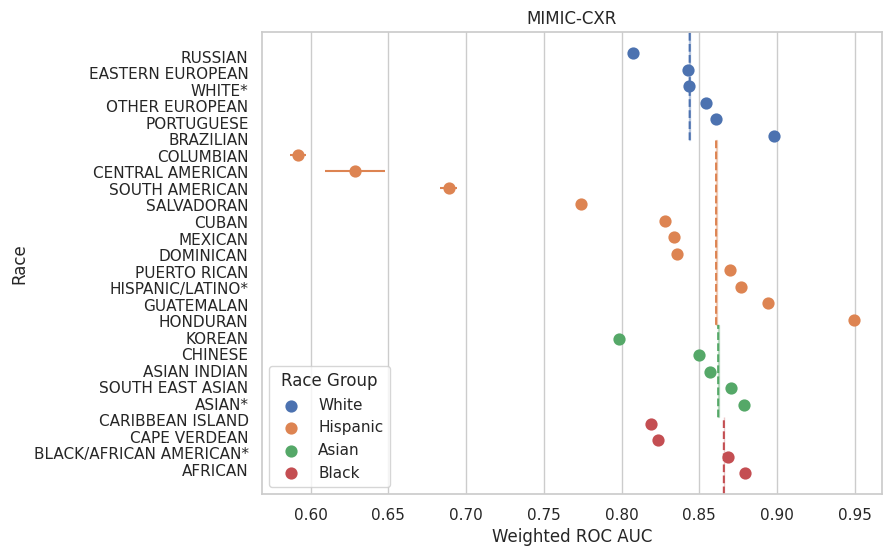

In [70]:
var = 'Weighted ROC AUC'
import seaborn as sns

#For a given variable 'var', organize the dataframe by ascending order of the metric with respect to the coarse race label
sns.set(style="whitegrid")
var_df2 = df_average.sort_values([var],ascending=True).groupby('Race Group').head(50)
group_order = var_df2[var_df2['Race'].str.contains('\*')].sort_values([var]).head(4)['Race Group'].array
group_order = group_order.tolist()
race_noramlized_counts = var_df2['Race Group'].value_counts()/var_df2['Race Group'].count()

var_df2 = df_average.sort_values(by=['Race Group', var], key=lambda x: pd.Categorical(x, categories=group_order)).head(50)

#Then within the each coarse race label, organize the dataframe using the sort_by_group_and_var to sort by granular label
var_df2 = sort_by_group_and_var(var_df2, 'Race Group', var, True)

#Rearrage lower and upper ci dataframes by the previously outlined ordering done by the metric of interest
df_lower_ci2 = df_lower_ci.set_index('Race')
df_lower_ci2 = df_lower_ci2.reindex(index=var_df2['Race'])
df_lower_ci2 = df_lower_ci2.reset_index()

df_upper_ci2 = df_upper_ci.set_index('Race')
df_upper_ci2 = df_upper_ci2.reindex(index=var_df2['Race'])
df_upper_ci2 = df_upper_ci2.reset_index()

# Create the forest plot
plt.figure(figsize=(8, 6))
target_races = ['ASIAN*', 'BLACK*', 'HISPANIC*', 'WHITE*']
for target_race in target_races:
  # Filter the dataframe for the target race and plot the metric and associated ci for the coarse race label
  target_race_df = var_df2[var_df2['Race'] == target_race]
  target_group = target_race_df['Race Group'].iloc[0]
  target_x = target_race_df[var].iloc[0]
  ind = group_order.index(target_group)

  lower_ci_target_df = df_lower_ci2[df_lower_ci2['Race'] == target_race]
  upper_ci_target_df = df_upper_ci2[df_upper_ci2['Race'] == target_race]
  y_max = 1-sum([race_noramlized_counts[group_order[i]] for i in range(ind)])
  y_min = y_max-race_noramlized_counts[group_order[ind]]
  midpoint = (lower_ci_target_df[var].array[0] + upper_ci_target_df[var].array[0])/2
  line_y =np.linspace(y_min, y_max, 10)
  line_x = np.repeat(midpoint, 10)
  plt.axvspan(lower_ci_target_df[var].array[0], upper_ci_target_df[var].array[0], y_min, y_max, color = sns.color_palette(palette = None, n_colors = 4)[ind], alpha=0.3)
  plt.axvline(x = midpoint, ymin = y_min, ymax = y_max, color = sns.color_palette(palette = None, n_colors = 4)[ind], linestyle = 'dashed', snap=False)

#Remove the coarse race label from the datframes of interest
var_df2 = var_df2[var_df2.Race != 'ASIAN*']
var_df2 = var_df2[var_df2.Race != 'BLACK*']
var_df2 = var_df2[var_df2.Race != 'HISPANIC*']
var_df2 = var_df2[var_df2.Race != 'WHITE*']
df_lower_ci2 = df_lower_ci2[df_lower_ci2.Race != 'ASIAN*']
df_lower_ci2 = df_lower_ci2[df_lower_ci2.Race != 'BLACK*']
df_lower_ci2 = df_lower_ci2[df_lower_ci2.Race != 'HISPANIC*']
df_lower_ci2 = df_lower_ci2[df_lower_ci2.Race != 'WHITE*']
df_upper_ci2 = df_upper_ci2[df_upper_ci2.Race != 'ASIAN*']
df_upper_ci2 = df_upper_ci2[df_upper_ci2.Race != 'BLACK*']
df_upper_ci2 = df_upper_ci2[df_upper_ci2.Race != 'HISPANIC*']
df_upper_ci2 = df_upper_ci2[df_upper_ci2.Race != 'WHITE*']

var_df2 = var_df2.reset_index().drop('index', axis = 1)
df_lower_ci2 = df_lower_ci2.reset_index().drop('index', axis = 1)
df_upper_ci2 = df_upper_ci2.reset_index().drop('index', axis = 1)

var_df2['index_column'] = var_df2.index
df_lower_ci2['index_column'] = df_lower_ci2.index
df_upper_ci2['index_column'] = df_upper_ci2.index

#Plot the metric for each granular group
var_df3 = var_df2.copy()
var_df3.Race = [item[-1] for item in var_df3.Race.str.split('- ')]
var_df3.Race = [item[-1] for item in var_df3.Race.str.split('/')]
var_df3 = var_df3.replace(['ASIAN', 'AFRICAN AMERICAN', 'HISPANIC OR LATINO', 'WHITE'],['ASIAN*', 'BLACK/AFRICAN AMERICAN*', 'HISPANIC/LATINO*', 'WHITE*'])

ax = sns.pointplot(x=var, y='Race', hue='Race Group', data=var_df3,
              dodge=0.4, join=False, hue_order=group_order)

x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

indices = [x_coords.index(item) for item in x_coords if  item>=0]
x_coords = [x_coords[i] for i in indices]
y_coords = [y_coords[i] for i in indices]

#Plot error bars for each granular group
plt.errorbar(x=x_coords[0:5], y = y_coords[0:5], xerr=((var_df3[var][0:5] - df_lower_ci2[var][0:5]), (df_upper_ci2[var][0:5] - var_df3[var][0:5])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[0], zorder = 4)
plt.errorbar(x=x_coords[6:16], y = y_coords[6:16], xerr=((var_df3[var][6:16] - df_lower_ci2[var][6:16]), (df_upper_ci2[var][6:16] - var_df3[var][6:16])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[1], zorder = 4)
plt.errorbar(x=x_coords[17:21], y = y_coords[17:21], xerr=((var_df3[var][17:21] - df_lower_ci2[var][17:21]), (df_upper_ci2[var][17:21] - var_df3[var][17:21])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[2], zorder = 4)
plt.errorbar(x=x_coords[22:25], y = y_coords[22:25], xerr=((var_df3[var][22:25] - df_lower_ci2[var][22:25]), (df_upper_ci2[var][22:25] - var_df3[var][22:25])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[3], zorder = 4)


# Set plot title and labels
plt.title('MIMIC-CXR')
plt.xlabel(var)
plt.ylabel('Race')
# Show the plot
plt.show()

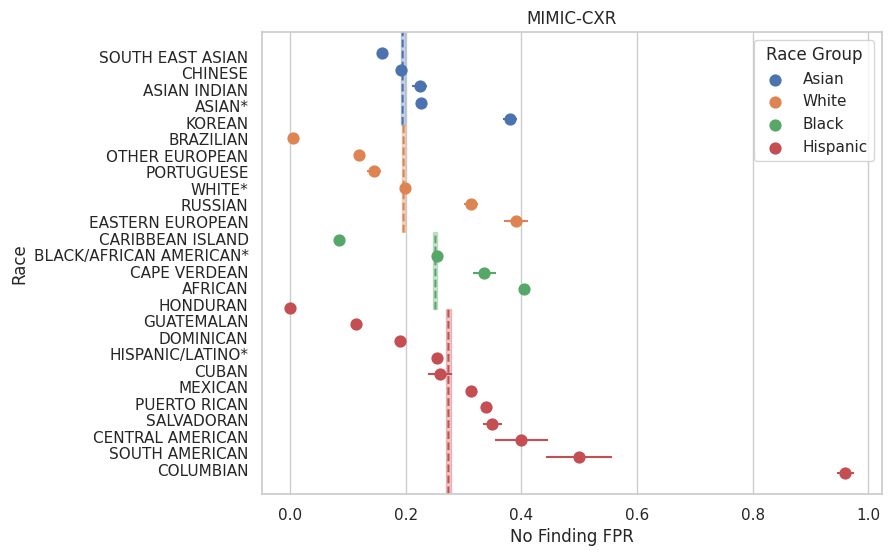

In [71]:
var = 'No Finding FPR'
import seaborn as sns

#Exact same code as before, the 'var' has changed to the 'No Finding FPR'
sns.set(style="whitegrid")
var_df2 = df_average.sort_values([var],ascending=True).groupby('Race Group').head(50)
group_order = var_df2[var_df2['Race'].str.contains('\*')].sort_values([var]).head(4)['Race Group'].array
group_order = group_order.tolist()
race_noramlized_counts = var_df2['Race Group'].value_counts()/var_df2['Race Group'].count()

var_df2 = df_average.sort_values(by=['Race Group', var], key=lambda x: pd.Categorical(x, categories=group_order)).head(50)
var_df2 = sort_by_group_and_var(var_df2, 'Race Group', var, True)

df_lower_ci2 = df_lower_ci.set_index('Race')
df_lower_ci2 = df_lower_ci2.reindex(index=var_df2['Race'])
df_lower_ci2 = df_lower_ci2.reset_index()

df_upper_ci2 = df_upper_ci.set_index('Race')
df_upper_ci2 = df_upper_ci2.reindex(index=var_df2['Race'])
df_upper_ci2 = df_upper_ci2.reset_index()

# Create the forest plot
plt.figure(figsize=(8, 6))
target_races = ['ASIAN*', 'BLACK*', 'HISPANIC*', 'WHITE*']
for target_race in target_races:
  # Filter the dataframe for the target race
  target_race_df = var_df2[var_df2['Race'] == target_race]
  target_group = target_race_df['Race Group'].iloc[0]
  target_x = target_race_df[var].iloc[0]
  ind = group_order.index(target_group)

  lower_ci_target_df = df_lower_ci2[df_lower_ci2['Race'] == target_race]
  upper_ci_target_df = df_upper_ci2[df_upper_ci2['Race'] == target_race]
  y_max = 1-sum([race_noramlized_counts[group_order[i]] for i in range(ind)])
  y_min = y_max-race_noramlized_counts[group_order[ind]]
  midpoint = (lower_ci_target_df[var].array[0] + upper_ci_target_df[var].array[0])/2
  line_y =np.linspace(y_min, y_max, 10)
  line_x = np.repeat(midpoint, 10)
  plt.axvspan(lower_ci_target_df[var].array[0], upper_ci_target_df[var].array[0], y_min, y_max, color = sns.color_palette(palette = None, n_colors = 4)[ind], alpha=0.3)
  plt.axvline(x = midpoint, ymin = y_min, ymax = y_max, color = sns.color_palette(palette = None, n_colors = 4)[ind], linestyle = 'dashed', snap=False)

var_df2 = var_df2[var_df2.Race != 'ASIAN*']
var_df2 = var_df2[var_df2.Race != 'BLACK*']
var_df2 = var_df2[var_df2.Race != 'HISPANIC*']
var_df2 = var_df2[var_df2.Race != 'WHITE*']
df_lower_ci2 = df_lower_ci2[df_lower_ci2.Race != 'ASIAN*']
df_lower_ci2 = df_lower_ci2[df_lower_ci2.Race != 'BLACK*']
df_lower_ci2 = df_lower_ci2[df_lower_ci2.Race != 'HISPANIC*']
df_lower_ci2 = df_lower_ci2[df_lower_ci2.Race != 'WHITE*']
df_upper_ci2 = df_upper_ci2[df_upper_ci2.Race != 'ASIAN*']
df_upper_ci2 = df_upper_ci2[df_upper_ci2.Race != 'BLACK*']
df_upper_ci2 = df_upper_ci2[df_upper_ci2.Race != 'HISPANIC*']
df_upper_ci2 = df_upper_ci2[df_upper_ci2.Race != 'WHITE*']

var_df2 = var_df2.reset_index().drop('index', axis = 1)
df_lower_ci2 = df_lower_ci2.reset_index().drop('index', axis = 1)
df_upper_ci2 = df_upper_ci2.reset_index().drop('index', axis = 1)

var_df2['index_column'] = var_df2.index
df_lower_ci2['index_column'] = df_lower_ci2.index
df_upper_ci2['index_column'] = df_upper_ci2.index

var_df3 = var_df2.copy()
var_df3.Race = [item[-1] for item in var_df3.Race.str.split('- ')]
var_df3.Race = [item[-1] for item in var_df3.Race.str.split('/')]
var_df3 = var_df3.replace(['ASIAN', 'AFRICAN AMERICAN', 'HISPANIC OR LATINO', 'WHITE'],['ASIAN*', 'BLACK/AFRICAN AMERICAN*', 'HISPANIC/LATINO*', 'WHITE*'])

ax = sns.pointplot(x=var, y='Race', hue='Race Group', data=var_df3,
              dodge=0.4, join=False, hue_order=group_order)

x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

indices = [x_coords.index(item) for item in x_coords if  item>=0]
x_coords = [x_coords[i] for i in indices]
y_coords = [y_coords[i] for i in indices]

plt.errorbar(x=x_coords[0:5], y = y_coords[0:5], xerr=((var_df3[var][0:5] - df_lower_ci2[var][0:5]), (df_upper_ci2[var][0:5] - var_df3[var][0:5])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[0], zorder = 4)
plt.errorbar(x=x_coords[6:11], y = y_coords[6:11], xerr=((var_df3[var][6:11] - df_lower_ci2[var][6:11]), (df_upper_ci2[var][6:11] - var_df3[var][6:11])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[1], zorder = 4)
plt.errorbar(x=x_coords[12:15], y = y_coords[12:15], xerr=((var_df3[var][12:15] - df_lower_ci2[var][12:15]), (df_upper_ci2[var][12:15] - var_df3[var][12:15])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[2], zorder = 4)
plt.errorbar(x=x_coords[16:27], y = y_coords[16:27], xerr=((var_df3[var][16:27] - df_lower_ci2[var][16:27]), (df_upper_ci2[var][16:27] - var_df3[var][16:27])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[3], zorder = 4)


# Set plot title and labels
plt.title('MIMIC-CXR')
plt.xlabel(var)
plt.ylabel('Race')
# Show the plot
plt.show()